<a href="https://colab.research.google.com/github/DoanJ7313/Python-Tutorials-Semnani-2024/blob/main/2025/3D_GAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
"""
Implementation based on original paper NeurIPS 2016 https://papers.nips.cc/paper/6096-learning-a-probabilistic-latent-space-of-object-shapes-via-3d-generative-adversarial-modeling.pdf
"""


'\nImplementation based on original paper NeurIPS 2016 https://papers.nips.cc/paper/6096-learning-a-probabilistic-latent-space-of-object-shapes-via-3d-generative-adversarial-modeling.pdf\n'

## Discriminator

In [6]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels=3, dim=64, out_conv_channels=512):
        super(Discriminator, self).__init__()
        conv1_channels = int(out_conv_channels / 8)
        conv2_channels = int(out_conv_channels / 4)
        conv3_channels = int(out_conv_channels / 2)
        self.out_conv_channels = out_conv_channels
        self.out_dim = int(dim / 16)

        self.conv1 = nn.Sequential(
            nn.Conv3d(
                in_channels=in_channels, out_channels=conv1_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv1_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv2_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv3_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv3_channels, out_channels=out_conv_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(out_conv_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(out_conv_channels * self.out_dim * self.out_dim * self.out_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply linear + sigmoid
        x = x.view(-1, self.out_conv_channels * self.out_dim * self.out_dim * self.out_dim)
        x = self.out(x)
        return x


## Generator

In [4]:
class Generator(torch.nn.Module):
    def __init__(self, in_channels=512, out_dim=64, out_channels=1, noise_dim=200, activation="sigmoid"):
        super(Generator, self).__init__()
        self.in_channels = in_channels
        self.out_dim = out_dim
        self.in_dim = int(out_dim / 16)
        conv1_out_channels = int(self.in_channels / 2.0)
        conv2_out_channels = int(conv1_out_channels / 2)
        conv3_out_channels = int(conv2_out_channels / 2)

        self.linear = torch.nn.Linear(noise_dim, in_channels * self.in_dim * self.in_dim * self.in_dim)

        self.conv1 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=in_channels, out_channels=conv1_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv1_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv2_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv2_out_channels, out_channels=conv3_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv3_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv3_out_channels, out_channels=out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            )
        )
        if activation == "sigmoid":
            self.out = torch.nn.Sigmoid()
        else:
            self.out = torch.nn.Tanh()

    def project(self, x):
        """
        projects and reshapes latent vector to starting volume
        :param x: latent vector
        :return: starting volume
        """
        return x.view(-1, self.in_channels, self.in_dim, self.in_dim, self.in_dim)

    def forward(self, x):
        x = self.linear(x)
        x = self.project(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return self.out(x)


## Test

In [9]:
def test_gan3d(print_summary=True):
    noise_dim = 200 # latent space vector dim
    in_channels = 512 # convolutional channels
    dim = 64  # cube volume
    model_generator = Generator(in_channels=512, out_dim=dim, out_channels=1, noise_dim=noise_dim)
    noise = torch.rand(1, noise_dim)
    generated_volume = model_generator(noise)
    print("Generator output shape", generated_volume.shape)
    model_discriminator = Discriminator(in_channels=1, dim=dim, out_conv_channels=in_channels)
    out = model_discriminator(generated_volume)
    print("Discriminator output", out.item())
    if print_summary:
      print("\n\nGenerator summary\n\n")
      summary(model_generator, (1, noise_dim))
      print("\n\nDiscriminator summary\n\n")
      summary(model_discriminator, (1,dim,dim,dim))
    return generated_volume

generated_volume = test_gan3d()

Generator output shape torch.Size([1, 1, 64, 64, 64])
Discriminator output 0.4589482247829437


Generator summary


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 32768]       6,586,368
   ConvTranspose3d-2         [-1, 256, 8, 8, 8]       8,388,608
       BatchNorm3d-3         [-1, 256, 8, 8, 8]             512
              ReLU-4         [-1, 256, 8, 8, 8]               0
   ConvTranspose3d-5      [-1, 128, 16, 16, 16]       2,097,152
       BatchNorm3d-6      [-1, 128, 16, 16, 16]             256
              ReLU-7      [-1, 128, 16, 16, 16]               0
   ConvTranspose3d-8       [-1, 64, 32, 32, 32]         524,288
       BatchNorm3d-9       [-1, 64, 32, 32, 32]             128
             ReLU-10       [-1, 64, 32, 32, 32]               0
  ConvTranspose3d-11        [-1, 1, 64, 64, 64]           4,096
          Sigmoid-12        [-1, 1, 64, 64, 64]    

In [20]:
def show_slices(volume):
    volume = volume.squeeze().detach().cpu().numpy()  # Shape: [64, 64, 64]
    mid = volume.shape[0] // 2
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(volume[mid, :, :], cmap="gray")
    axes[0].set_title("Axial (XY) Slice")
    axes[1].imshow(volume[:, mid, :], cmap="gray")
    axes[1].set_title("Coronal (XZ) Slice")
    axes[2].imshow(volume[:, :, mid], cmap="gray")
    axes[2].set_title("Sagittal (YZ) Slice")
    plt.tight_layout()
    plt.show()

def plot_voxels(volume, threshold=0.5):
    volume = volume.squeeze().detach().cpu().numpy()
    filled = volume > threshold
    x, y, z = np.where(filled)
    fig = go.Figure(data=go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=2,
            color=volume[filled],  # Optional: grayscale intensity
            colorscale='Viridis',
            opacity=0.7
        )
    ))
    fig.update_layout(
        scene=dict(aspectmode='data'),
        title="3D Voxel Plot"
    )
    fig.show()

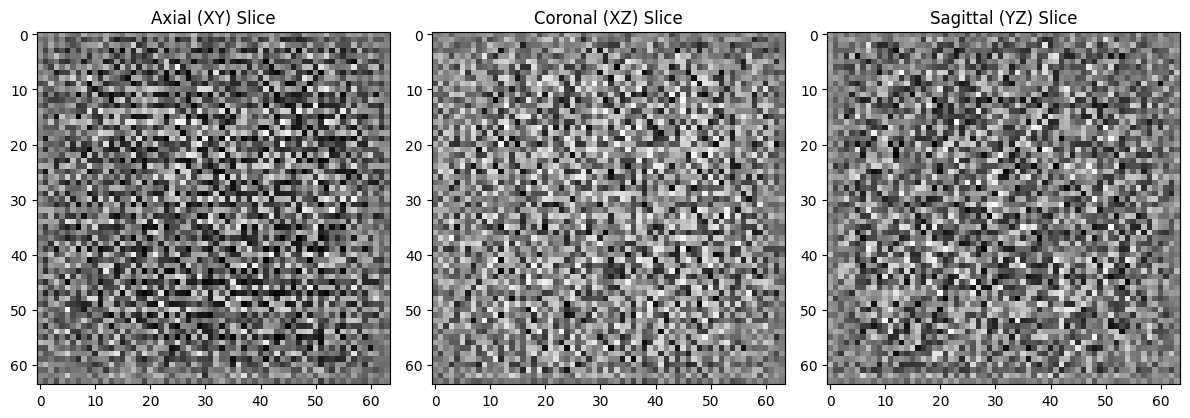

In [21]:
show_slices(generated_volume)

In [18]:
plot_voxels(generated_volume)